In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install librosa

In [4]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# **Pre-Processing**

In [5]:
def load_and_split_audio(directory, segment_length=10):
    audio_segments = []
    file_names = []
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            file_path = os.path.join(directory, filename)
            audio, sr = librosa.load(file_path, sr=22050) ## (Set the hop length; at 22050 Hz, 512 samples ~= 23ms)Provided in Documantation
            total_length = len(audio) / sr
            num_segments = int(total_length // segment_length)
            for i in range(num_segments):
                start_sample = int(i * segment_length * sr)
                end_sample = int((i + 1) * segment_length * sr)
                segment = audio[start_sample:end_sample]
                audio_segments.append(segment)
                audio_name = os.path.splitext(filename)[0]
                file_names.append(f"{audio_name}_segment_{i + 1}")
    return audio_segments, file_names

def extract_features_from_segments(segments, sr=22050):#Feature Extraxtion
    features = []
    for segment in segments:
        chroma = librosa.feature.chroma_stft(y=segment, sr=sr)
        rms = librosa.feature.rms(y=segment)
        spectral_centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr, roll_percent=0.85)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=segment)
        onset_env = librosa.onset.onset_strength(y=segment, sr=sr)
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
        mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)
        segment_features = [
            np.mean(chroma), np.var(chroma),
            np.mean(rms), np.var(rms),
            np.mean(spectral_centroid), np.var(spectral_centroid),
            np.mean(spectral_bandwidth), np.var(spectral_bandwidth),
            np.mean(rolloff), np.var(rolloff),
            np.mean(zero_crossing_rate), np.var(zero_crossing_rate),
            tempo, tempo ** 2
        ]

        segment_features.extend([np.mean(mfcc) for mfcc in mfccs])
        segment_features.extend([np.var(mfcc) for mfcc in mfccs])

        features.append(segment_features)

    return features

def preprocess_dataset(dataset_path, label):
    segments, file_names = load_and_split_audio(dataset_path)  # Split into 10-second segments(300+300)
    features = extract_features_from_segments(segments)
    labels = [label] * len(file_names)
    return np.array(features), file_names, labels

In [6]:
classical_path = '/content/drive/MyDrive/Data (1)/genres_original/classical'
rock_path = '/content/drive/MyDrive/Data (1)/genres_original/rock'

# Get features for all 10-second segments from Classical dataset
X_classical, classical_file_names, classical_labels = preprocess_dataset(classical_path, 0)  # Label 0 for Classical
print("Shape of X_classical:", X_classical.shape)


X_rock, rock_file_names, rock_labels = preprocess_dataset(rock_path, 1)  # Label 1 for Rock
print("Shape of X_rock:", X_rock.shape)

columns = []

features_names = [
    'Chroma_Mean', 'Chroma_Var',
    'RMS_Mean', 'RMS_Var',
    'Spectral_Centroid_Mean', 'Spectral_Centroid_Var',
    'Spectral_Bandwidth_Mean', 'Spectral_Bandwidth_Var',
    'Rolloff_Mean', 'Rolloff_Var',
    'Zero_Crossing_Rate_Mean', 'Zero_Crossing_Rate_Var',
    'Tempo', 'Tempo_Var'
]


for i in range(1, 14):  # 13 MFCCs
    columns.append(f'MFCC_{i}_Mean')
    columns.append(f'MFCC_{i}_Var')

    #Total 26+14

columns = features_names + columns + ['Label']

df_classical = pd.DataFrame(X_classical, index=classical_file_names, columns=columns[:-1])
df_classical['Label'] = classical_labels
df_rock = pd.DataFrame(X_rock, index=rock_file_names, columns=columns[:-1])
df_rock['Label'] = rock_labels  # Add the labels column

df_combined = pd.concat([df_classical, df_rock])

csv_file_path = '/content/drive/MyDrive/Data (1)/X_combined_features_with_labels.csv'
df_combined.to_csv(csv_file_path)

print(f"Combined features with numeric labels saved to {csv_file_path}")


<ipython-input-5-9724c3803161>:29: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]


Shape of X_classical: (298, 40)
Shape of X_rock: (299, 40)
Combined features with numeric labels saved to /content/drive/MyDrive/Data (1)/X_combined_features_with_labels.csv


# CSV Created


In [7]:
df = pd.read_csv('/content/drive/MyDrive/Data (1)/X_combined_features_with_labels.csv')
df.head()

,Unnamed: 0,Chroma_Mean,Chroma_Var,RMS_Mean,RMS_Var,Spectral_Centroid_Mean,Spectral_Centroid_Var,Spectral_Bandwidth_Mean,Spectral_Bandwidth_Var,Rolloff_Mean,...,MFCC_9_Var,MFCC_10_Mean,MFCC_10_Var,MFCC_11_Mean,MFCC_11_Var,MFCC_12_Mean,MFCC_12_Var,MFCC_13_Mean,MFCC_13_Var,Label
0,classical.00005_segment_1,0.268971,0.082038,0.051483,0.000221,1448.915304,79143.813348,1612.102357,24865.942427,2881.702142,...,48.248810,32.568710,40.499657,45.783978,42.064583,56.127186,52.992096,59.905727,84.929558,0
1,classical.00005_segment_2,0.259759,0.082955,0.027707,0.000638,1396.041828,54448.668663,1485.851596,44492.905704,2730.844817,...,130.727310,156.077942,110.653801,98.802513,100.438461,93.280563,53.012688,128.643250,74.117706,0
2,classical.00005_segment_3,0.279303,0.083637,0.050422,0.000534,1450.237868,86523.088165,1579.863350,40509.189607,2897.414885,...,64.454124,35.482224,59.995808,46.960171,54.079063,55.546276,57.291588,61.635605,47.750668,0
3,classical.00003_segment_1,0.218046,0.083894,0.030619,0.000251,1609.284528,68535.496299,1469.741109,59148.865353,2976.703037,...,51.189938,99.435852,76.592926,76.111259,86.684814,75.861549,121.830490,173.940033,137.660049,0
4,classical.00003_segment_2,0.237626,0.082141,0.023638,0.000447,1435.281689,110319.567445,1556.182488,71755.695264,2823.197778,...,194.647934,108.609848,66.097504,85.594559,92.703835,78.202248,105.029129,128.520432,122.339172,0


In [8]:
df.shape

(597, 42)

In [9]:
df.iloc[1,:]

,1
Unnamed: 0,classical.00005_segment_2
Chroma_Mean,0.259759
Chroma_Var,0.082955
RMS_Mean,0.027707
RMS_Var,0.000638
Spectral_Centroid_Mean,1396.041828
Spectral_Centroid_Var,54448.668663
Spectral_Bandwidth_Mean,1485.851596
Spectral_Bandwidth_Var,44492.905704
Rolloff_Mean,2730.844817


In [10]:
df.isna().sum()

,0
Unnamed: 0,0
Chroma_Mean,0
Chroma_Var,0
RMS_Mean,0
RMS_Var,0
Spectral_Centroid_Mean,0
Spectral_Centroid_Var,0
Spectral_Bandwidth_Mean,0
Spectral_Bandwidth_Var,0
Rolloff_Mean,0


# Training- Testing


In [11]:
from sklearn.model_selection import train_test_split

# Define features and labels
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) ## Can be startified at y for almost equal 1 and 0 in y

# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)
print("Training set class distribution:")
print(y_train.value_counts())
print("\nTesting set class distribution:")
print(y_test.value_counts())


Training set shape: (477, 40) (477,)
Testing set shape: (120, 40) (120,)
Training set class distribution:
Label
1    246
0    231
Name: count, dtype: int64

Testing set class distribution:
Label
0    67
1    53
Name: count, dtype: int64


In [12]:
X_test = pd.DataFrame(X_test, columns=X.columns)
X_test.head(10)

,Chroma_Mean,Chroma_Var,RMS_Mean,RMS_Var,Spectral_Centroid_Mean,Spectral_Centroid_Var,Spectral_Bandwidth_Mean,Spectral_Bandwidth_Var,Rolloff_Mean,Rolloff_Var,...,MFCC_9_Mean,MFCC_9_Var,MFCC_10_Mean,MFCC_10_Var,MFCC_11_Mean,MFCC_11_Var,MFCC_12_Mean,MFCC_12_Var,MFCC_13_Mean,MFCC_13_Var
109,0.265641,0.084996,0.008776,0.000025,744.963057,11064.905215,1155.977321,28463.880106,1090.574303,6.009890e+04,...,33.906784,51.826103,36.269783,61.836304,35.052734,43.038143,40.915657,48.893089,31.736687,22.275558
480,0.420036,0.075587,0.182039,0.001905,3429.478141,257571.544836,2976.700494,51059.598209,7102.085052,8.824409e+05,...,106.116119,97.548409,73.396065,70.549408,42.706596,48.203876,45.702068,44.825932,27.067333,28.480143
135,0.318946,0.080117,0.113050,0.000761,2056.790954,54822.618555,2144.913852,33489.351000,4076.620051,3.323259e+05,...,28.306862,32.319248,22.242727,32.823433,29.319757,32.998577,50.031025,32.962479,52.032005,32.932827
77,0.220707,0.080693,0.143350,0.004373,1398.777162,42173.578817,1457.988975,31569.434532,2355.162866,2.064424e+05,...,85.833710,86.417442,25.326893,33.906952,33.475132,35.687057,34.623703,54.000153,62.769463,51.587307
396,0.403004,0.076549,0.128516,0.001978,2755.860644,356548.314418,2817.295763,99543.791624,5857.331016,2.310787e+06,...,73.272820,127.853691,38.428185,43.072605,51.866009,51.353085,39.671795,25.474827,25.385620,33.420238
286,0.204377,0.084747,0.022047,0.000093,2324.819777,139162.372070,2007.467459,43906.711920,4527.093662,6.514934e+05,...,49.992878,36.015675,58.039879,35.329441,36.090160,60.891354,140.026840,138.226837,126.796967,67.668205
10,0.232835,0.085800,0.043963,0.000166,1788.786686,73460.972672,1661.490226,30731.035060,3298.502019,3.651540e+05,...,56.606434,71.430473,61.199566,52.066551,127.699913,88.962959,84.408554,186.126373,136.107422,112.851669
589,0.412376,0.075753,0.105456,0.000224,2463.656369,155774.907360,2094.757178,31622.391341,4683.396738,6.142370e+05,...,73.972397,43.531708,32.049187,39.998116,46.042809,36.953251,32.776810,31.272921,22.774969,40.702980
78,0.302075,0.086406,0.034891,0.000530,1601.346673,141608.635315,1490.152600,26497.654919,2912.303271,2.795579e+05,...,116.402428,184.060791,59.129074,101.616547,66.911156,116.287567,94.865738,76.925117,157.372284,113.067848
416,0.427902,0.080715,0.125236,0.001698,2561.741584,300254.912098,2510.538733,155717.257307,5188.652616,1.660057e+06,...,168.987930,66.312157,74.248123,131.647278,82.578598,69.447464,43.372131,29.134031,64.208000,52.654076


In [13]:
X.shape


(597, 40)

In [14]:
y.shape

(597,)

# Standard- Scaling

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#I had made this pkl file for scaling(mean=0) for support in flask
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [19]:
X_train #scaled between [-1,1]

array([[-1.26560181,  0.27805346, -0.74875357, ...,  0.52421103,
         1.07143786,  0.39485314],
       [ 0.41099732,  0.39944626, -0.53391257, ...,  0.5783133 ,
        -0.52714363, -0.43670925],
       [-0.57667947, -1.10928454, -0.08426243, ...,  0.06055273,
        -0.51239932, -0.78641197],
       ...,
       [ 0.05405604, -0.88866801, -1.23316836, ..., -0.69451644,
        -0.57393569, -0.23384989],
       [ 1.44451325,  0.66116813,  0.83274564, ..., -0.57934616,
        -0.3615371 , -0.5733525 ],
       [-0.73702449, -0.1982217 , -0.50674146, ...,  0.13831962,
        -0.24614587, -0.34719539]])

# Support Vector Machine


Training Accuracy: 0.9958071278825996
Testing Accuracy: 0.9833333333333333
Precision: 0.9833333333333333
Recall: 0.9833333333333333
F1 Score: 0.9833333333333333
SVM model saved as 'svm_model.pkl'


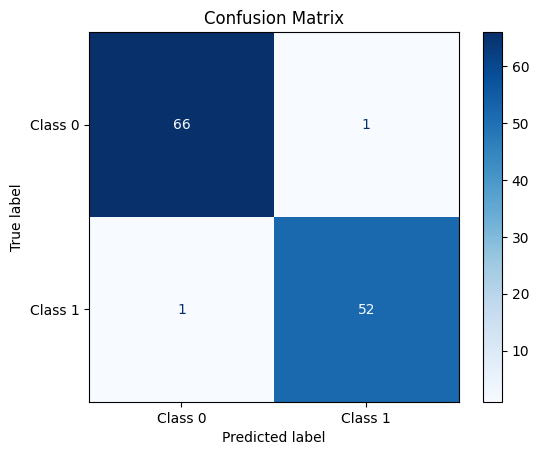

In [32]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import pickle
import matplotlib.pyplot as plt

svm_model = SVC(kernel='linear', C=1, random_state=42) #2 class, so using linear
svm_model.fit(X_train, y_train)


y_train_pred = svm_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
y_test_pred = svm_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)


precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Save the model
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)

print("SVM model saved as 'svm_model.pkl'")

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Decision Tree


DT model saved as 'DT_model.pkl'
Training Accuracy: 1.0
Testing Accuracy: 0.9416666666666667
Precision: 0.9419051627384962
Recall: 0.9416666666666667
F1 Score: 0.9417199540908345


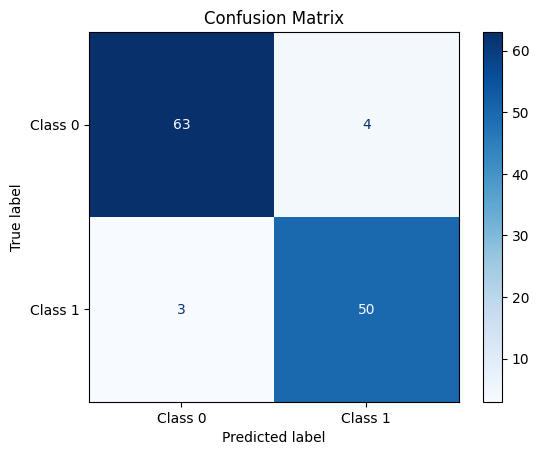

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

dt_model = DecisionTreeClassifier(random_state=42)

dt_model.fit(X_train, y_train)

y_train_pred = dt_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred = dt_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
with open('DT_model.pkl', 'wb') as file:
    pickle.dump(dt_model, file)

print("DT model saved as 'DT_model.pkl'")

precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Random Forest


Training Accuracy: 1.0
Testing Accuracy: 0.975
Precision: 0.9750848416289593
Recall: 0.975
F1 Score: 0.9749735449735449


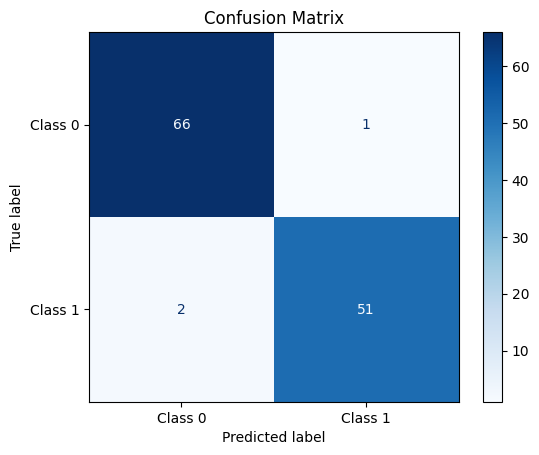

rf model saved as 'rf_model.pkl'


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_train_pred = rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

print("rf model saved as 'rf_model.pkl'")


# K- Nearest Neighbour

Training Accuracy: 1.0
Testing Accuracy: 0.9833333333333333
Precision: 0.9838164251207729
Recall: 0.9833333333333333
F1 Score: 0.9832956259426847


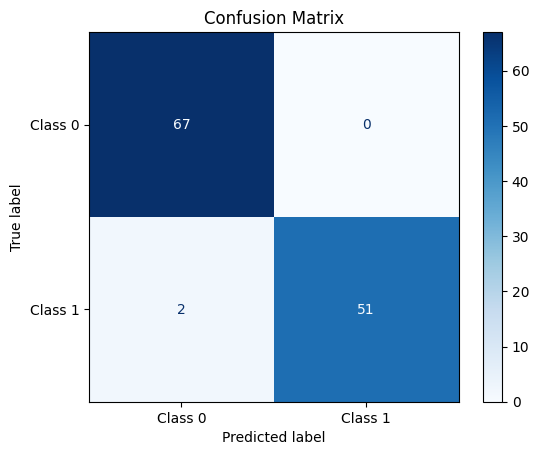

knn model saved as 'knn_model.pkl'


In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train, y_train)

y_train_pred = knn_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train)
y_test_pred = knn_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

with open('knn_model.pkl', 'wb') as file:
    pickle.dump(knn_model, file)
print("knn model saved as 'knn_model.pkl'")


# Logistic Regression

Training Accuracy: 0.9958071278825996
Testing Accuracy: 0.9833333333333333
Precision: 0.9833333333333333
Recall: 0.9833333333333333
F1 Score: 0.9833333333333333


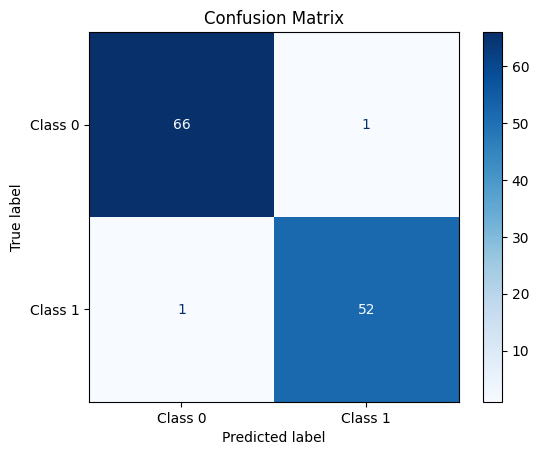

logistic model saved as 'logistic_model.pkl'


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# Initialize the Logistic Regression model
logistic_model = LogisticRegression()


logistic_model.fit(X_train, y_train)
y_train_pred = logistic_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Make predictions on test data
y_test_pred = logistic_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

with open('logistic_model.pkl', 'wb') as file:
    pickle.dump(logistic_model, file)

print("logistic model saved as 'logistic_model.pkl'")
